# Определение перспективного тарифа для телеком компании

**В нашем распоряжении данные 500 пользователей оператора связи «Мегалайн»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра», Нужно проанализировать поведение клиентов, необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов и сделать вывод — какой тариф лучше.**

*Описание данных:*

-Таблица users (информация о пользователях):
  - user_id — уникальный идентификатор пользователя
  - first_name — имя пользователя
  - last_name — фамилия пользователя
  - age — возраст пользователя (годы)
  - reg_date — дата подключения тарифа (день, месяц, год)
  - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки   данных)
  - city — город проживания пользователя
  - tariff — название тарифного плана


-Таблица calls (информация о звонках):
  - id — уникальный номер звонка
  - call_date — дата звонка
  - duration — длительность звонка в минутах
  - user_id — идентификатор пользователя, сделавшего звонок


-Таблица messages (информация о сообщениях):
  - id — уникальный номер сообщения
  - message_date — дата сообщения
  - user_id — идентификатор пользователя, отправившего сообщение


-Таблица internet (информация об интернет-сессиях):
  - id — уникальный номер сессии
  - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
  - session_date — дата интернет-сессии
  - user_id — идентификатор пользователя


-Таблица tariffs (информация о тарифах):
  - tariff_name — название тарифа
  - rub_monthly_fee — ежемесячная абонентская плата в рублях
  - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
  - messages_included — количество сообщений в месяц, включённых в абонентскую плату
  - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
  - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то   - со 101 минуты будет взиматься плата)
  - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
  - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

###  Открытие файла с данными и изучение общей информации. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import factorial
import seaborn as sns
from scipy import stats as st
users = pd.read_csv('/datasets/users.csv', sep=',')
calls = pd.read_csv('/datasets/calls.csv', sep=',')
messages = pd.read_csv('/datasets/messages.csv', sep=',')
internet = pd.read_csv('/datasets/internet.csv', sep=',')
tariffs = pd.read_csv('/datasets/tariffs.csv', sep=',')


В таблице users (информация о пользователях) выборка из 500 пользователей. В столбце churn_date — дата прекращения пользования тарифом много пропусков которые говорят что тариф ещё действовал на момент выгрузки данных)

В Таблице calls (информация о звонках) в глаза бросается в столбце duration — длительность звонка в минутах много нулевых значений,вероятнее всего это очень короткие звонки(возможно обрыв связи во время разговора) и так как тариф считается по минутам необходимо будет округлить нули до 1 минуты. Так же необходимо заменить тип данных в столбце call_date — дата звонка

Данные полные, пропусков нет. Аналогично заменим тип данных в датах отправки смс

Аналогично заменим тип данных в датах session_date

In [2]:
tariffs.info()
tariffs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Подготовка данных

В каждой из представленных таблиц есть столбец с датой - необходимо заменить тип данных

In [3]:
#заменяем тип данных в столбцах даты с objective на временной
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

Для дальнейшей работы добавляем столбец с месяцем в таблицы

In [4]:
calls['month'] = calls['call_date'].dt.month
messages['month'] = messages['message_date'].dt.month
internet['month'] = internet['session_date'].dt.month

In [5]:
#меняем вещественный тип данных в таблице calls столбце duration — длительность звонка в минутах  на целочисленный 
calls['duration'] = calls['duration'].apply(np.ceil)

 в таблице calls столбце duration — длительность звонка в минутах много нулевых значений и это явные ошибки в данных, вероятнее всего это очень короткие звонки, длительность которых измерить не получилось именно из-за их малой продолжительности. То есть по правилам тарифа, такие звонки надо округлять до одной минуты

In [6]:
# округлим нулевые данные длительности звонков в большую сторону до 1
calls.loc[calls['duration'] == 0, 'duration'] = 1

In [7]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

In [8]:
#аналогично округлению к большему в длительности звонков округляем использованные мегабайты в большую сторону до 1
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

In [9]:
# посмотрим количество самых минимальных значений
calls['duration'].value_counts().sort_index().head(5)

1.0    48015
2.0     9194
3.0    10362
4.0    10918
5.0    11411
Name: duration, dtype: int64

Удалять нулевые звонки - мы потеряем часть наших данных которые повлияют на общий анализ. поэтому звонки нулевой длительности будем округлять до одной минуты. Я это понимаю, как звонки, в которых соединение произошло, но на какое-то совсем ничтожное время, чтобы его замерила мониторинговая система
например-если клиент одной компании  звонит клиенту другого оператора и у последнего срабатывает автоответчик, то исходящий звонок тарифицируется. То есть он очень короткий типа 3 секунды или даже меньше, но его округляют до минуты и считают как исходящий.

In [10]:
calls.loc[calls['duration'] > 1, 'duration'] = calls['duration']+1

In [11]:
internet.loc[internet['mb_used'] >1, 'mb_used'] = internet['mb_used']+1

### Подготовка пользовательских данных (звонки, смс, объем трафика и т.д.)

Создадим новую таблицу в которую занесем данные для каждого пользователя:
    колличество и длительность произведенных звонков
    колличество отправленных сообщений
    объем использованных МБ интернета

In [12]:
#группируем новую таблицу из таблицы звонков
new_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])

In [13]:
#аналогично по таблице сообщений
new_messages = messages.groupby(['user_id', 'month'])['id'].count()

In [14]:
#аналогично по таблице интернета
new_internet = internet.groupby(['user_id', 'month']).sum()['mb_used']

Мы взяли из каждой таблицы необходимую информацию и формируем новую таблицу с нужными нам данными

In [15]:
# для нашего анализа данных формируем новую таблицу из сгруппированных выше
df = pd.concat([new_calls, new_messages, new_internet], axis=1)
df = df.reset_index()
df.head(10)

,user_id,month,count,sum,id,mb_used
0,1000,5,22.0,180.0,22.0,2261.0
1,1000,6,43.0,214.0,60.0,23306.0
2,1000,7,47.0,385.0,75.0,14045.0
3,1000,8,52.0,459.0,81.0,14099.0
4,1000,9,58.0,521.0,57.0,14608.0
5,1000,10,57.0,403.0,73.0,14744.0
6,1000,11,43.0,381.0,58.0,14792.0
7,1000,12,46.0,378.0,70.0,9848.0
8,1001,11,59.0,488.0,NaN,18507.0
9,1001,12,63.0,473.0,NaN,14094.0


In [16]:
#для лучшего восприятия переименуем столбцы
df.columns = ['user_id', 'month', 'calls_count', 'calls_len', 'messages', 'internet_mb']
df.head(10)

,user_id,month,calls_count,calls_len,messages,internet_mb
0,1000,5,22.0,180.0,22.0,2261.0
1,1000,6,43.0,214.0,60.0,23306.0
2,1000,7,47.0,385.0,75.0,14045.0
3,1000,8,52.0,459.0,81.0,14099.0
4,1000,9,58.0,521.0,57.0,14608.0
5,1000,10,57.0,403.0,73.0,14744.0
6,1000,11,43.0,381.0,58.0,14792.0
7,1000,12,46.0,378.0,70.0,9848.0
8,1001,11,59.0,488.0,NaN,18507.0
9,1001,12,63.0,473.0,NaN,14094.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month          3214 non-null int64
calls_count    3174 non-null float64
calls_len      3174 non-null float64
messages       2717 non-null float64
internet_mb    3203 non-null float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


В новой таблице видны пропуски в столбцах звонки количество и длительность а также в столбце использования смс и интернета. 
Можем предположить что некоторые пользователи не пользуются отправкой сообщений, что понятно-многие перешли в мессенджеры.
Естьь пользователи которые не совершали в этот период звонков и не пользовались мобильным интернетом.

In [18]:
df[(df['calls_count'].isnull()) & (df['internet_mb'].isnull()) & df['messages'].isnull()]

,user_id,month,calls_count,calls_len,messages,internet_mb


пользователей которые ни разу не совершали звонков, не отправляли сообщения а также не пользовались мобильным интернетом у нас нет, значит в каойто период они просто не пользовались какойто из услуг

In [19]:
#заменим пропуски нулями- значит в это время абонент не пользовался данной услугой
df=df.fillna(0)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 6 columns):
user_id        3214 non-null int64
month          3214 non-null int64
calls_count    3214 non-null float64
calls_len      3214 non-null float64
messages       3214 non-null float64
internet_mb    3214 non-null float64
dtypes: float64(4), int64(2)
memory usage: 150.8 KB


Добавим в нашу таблицу столбцы с тарифом и городом

In [21]:
new_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
df['tariffs'] = df['user_id'].map(new_tariff)

In [22]:
new_city = dict(pd.Series(users['city'].values, index=users['user_id']))
df['city'] = df['user_id'].map(new_city)

в таблице имеются следующие данные для каждого пользователя:

количество сделанных звонков и израсходованных минут разговора по месяцам;

количество отправленных сообщений по месяцам;

объем израсходованного интернет-трафика по месяцам;

 рассчитаем насколько превышены лимиты по звонкам, сообщениям, интернету

In [23]:
def extra_calls(row):
    if row['tariffs'] == 'smart':
        result = row['calls_len']-tariffs.loc[0, 'minutes_included']
        return np.where(result > 0, result, 0)
    else:
        result = row['calls_len']-tariffs.loc[1, 'minutes_included']
        return np.where(result > 0, result, 0)

In [24]:
# создаем столбец в таблице для превышающих лимит звонков
df['calls_extra'] = df.apply(extra_calls, axis=1)
df['calls_extra'] = df['calls_extra'].astype('int')

In [25]:
def extra_messages(row):
    if row['tariffs'] == 'smart':
        result = row['messages']-tariffs.loc[0, 'messages_included']
        return np.where(result > 0, result, 0)
    else:
        result = row['messages']-tariffs.loc[1, 'messages_included']
        return np.where(result > 0, result, 0)

In [26]:
# создаем столбец в таблице для превышающих лимит сообщений
df['messages_extra'] = df.apply(extra_messages, axis=1)
df['messages_extra'] = df['messages_extra'].astype('int')

In [27]:
def extra_internet(row):
    if row['tariffs'] == 'smart':
        result = row['internet_mb']-tariffs.loc[0, 'mb_per_month_included']
        return np.where(result > 0, result, 0)
    else:
        result = row['internet_mb']-tariffs.loc[1, 'mb_per_month_included']
        return np.where(result > 0, result, 0)

In [28]:
# создаем столбец в таблице для превышающих лимит мб интернета
df['internet_extra'] = df.apply(extra_internet, axis=1)
df['internet_extra'] = df['internet_extra'].apply(np.ceil)

Создаем в нашей таблице столбец с абонентской платой за месяц, чтоб найти сумму потраченных средств каждым пользователем

In [29]:
#столбец с абонентской платой
tariff_for_munth = {'smart': 550, 'ultra': 1950}
df['price_month'] = df['tariffs'].map(tariff_for_munth)

In [30]:
def extra_month(row):
    sum_for_month=0
    if row['tariffs'] == 'smart':
        sum_for_month += row['calls_extra']*tariffs.loc[0, 'rub_per_minute']
        sum_for_month += row['messages_extra']*tariffs.loc[0, 'rub_per_message']
        sum_for_month += row['internet_extra']/1024*tariffs.loc[0, 'rub_per_gb']
        return sum_for_month 
    else:
        sum_for_month += row['calls_extra']*tariffs.loc[1, 'rub_per_minute']
        sum_for_month += row['messages_extra']*tariffs.loc[1, 'rub_per_message']
        sum_for_month += row['internet_extra']/1024*tariffs.loc[1, 'rub_per_gb']
        return sum_for_month

In [31]:
# создаем столбец в таблице для суммы оплаты превышающих лимит
df['pay_extra'] = df.apply(extra_month, axis=1)

In [32]:
df['pay_extra'] = df.groupby('internet_extra')['pay_extra'].apply(np.ceil)

чтобы найти общую сумму потраченных за месяц средств просуммируем абон плату и сверх переплаты

In [33]:
df['all_pay'] = df['price_month'] + df['pay_extra']

### Анализ пользовательских данных

На этом этапе рассмотрим Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Рассчитаем среднее количество, дисперсию и стандартное отклонение

Построим диаграмму размаха для каждого из тарифов, В размах «усов» попадают нормальные значения, а за пределами находятся выбросы- их мы отсечем

calls_len


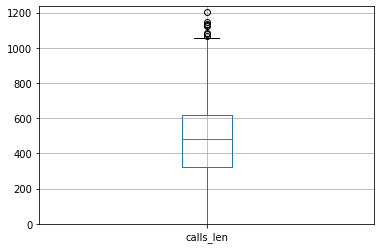

None
internet_mb


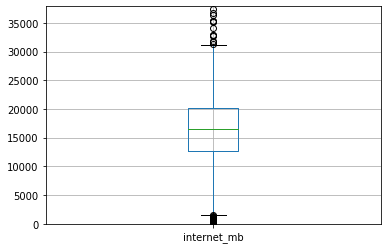

None
messages


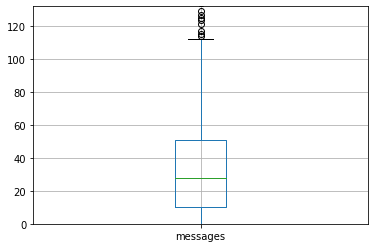

None


In [34]:
list = ['calls_len', 'internet_mb', 'messages']  # создаем список
for item in list:
    def analyze(item):
              print (item)
              percentile_95 = np.percentile(df.query('tariffs == "smart"')[item], 95)
             
              
              plt.ylim(0, percentile_95*1.5)
              df.query('tariffs == "smart"').boxplot(column = item)
              plt.show()
              df.query('tariffs == "smart"')[item].describe()
    print(analyze(item))

По диаграмме видно, что телефонные звонки продолжительностью более 1100 минут для нас неинформативны, их отбрасываем. Аналогично поступаем с СМС количество которых превышает 110, а так же использование мобильного интернета более 32000 МБ, то что меньше 2000 оставим-поскольку предполагаем что тариф используют разного рода и профессий люди-есть те кто использует его по минимуму

Аналогично строим диаграмму для тарифного плана УЛЬТРА

calls_len


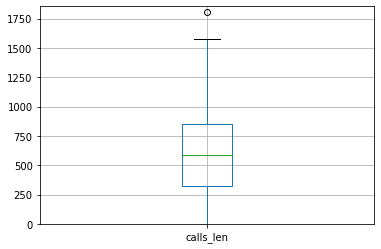

None
internet_mb


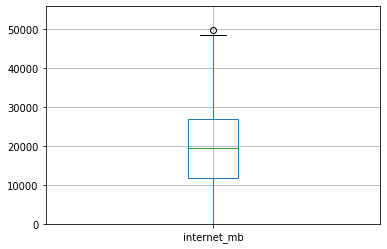

None
messages


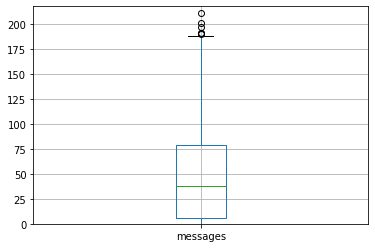

None


In [35]:
list = ['calls_len', 'internet_mb', 'messages']  # создаем список
for item in list:
    def analyze(item):
              print (item)
              percentile_95 = np.percentile(df.query('tariffs == "ultra"')[item], 95)
             
              
              plt.ylim(0, percentile_95*1.5)
              df.query('tariffs == "ultra"').boxplot(column = item)
              plt.show()
              df.query('tariffs == "ultra"')[item].describe()
    print(analyze(item))

С тарифом УЛЬТРА ситуация немного иная- отбрасываем звонки продолжительностью свыше 1600 минут, СМС количество которых превышает 185, а также интернет свыше 48000 МБ

Создаем столбцы со слишком длинными разговорами, большим количеством смс а также превышением трафика интернета

In [36]:
df['too_call'] = ((df['tariffs']=='smart') & (df['calls_len'] > 1100) | (df['tariffs']=='ultra') & (df['calls_len'] > 1600))
df['too_sms'] = ((df['tariffs']=='smart') & (df['messages'] > 110) | (df['tariffs']=='ultra') & (df['messages'] > 185))
df['too_inet'] = ((df['tariffs']=='smart') & (df['internet_mb'] > 32000) | (df['tariffs']=='ultra') & (df['internet_mb'] > 48000))    

Создаем новый датафрейм -чистый от аномальных значений

In [37]:
data = df[(df['too_call'] == False) & (df['too_sms'] == False) & (df['too_inet'] == False)].reset_index(drop=True)

In [38]:
data.describe()

,user_id,month,calls_count,calls_len,messages,internet_mb,calls_extra,messages_extra,price_month,pay_extra,all_pay
count,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000,3167.000000
mean,1251.495106,8.294916,62.615725,508.099463,37.331228,17153.791601,48.566467,3.616040,979.681086,554.925166,1534.606252
std,145.029846,2.908075,32.695301,268.592862,34.611103,7466.689371,96.690903,10.210097,645.801342,738.348622,758.117672
min,1000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,550.000000,0.000000,550.000000
25%,1123.000000,6.000000,40.000000,319.000000,9.000000,12504.500000,0.000000,0.000000,550.000000,0.000000,795.500000
50%,1253.000000,9.000000,62.000000,501.000000,30.000000,16940.000000,0.000000,0.000000,550.000000,174.000000,1684.000000
75%,1380.000000,11.000000,82.000000,665.000000,56.000000,21397.000000,52.000000,0.000000,1950.000000,927.500000,1950.000000
max,1499.000000,12.000000,196.000000,1580.000000,185.000000,45305.000000,585.000000,60.000000,1950.000000,4078.000000,4628.000000


от выбросов мы благополучно избавились

In [39]:
mediana_data = data.pivot_table(index='user_id', values=['calls_len', 'messages', 'internet_mb', 'all_pay'], aggfunc='median')

Добавим столбцы город и тариф

In [40]:
for user_id in users['user_id']:
    mediana_data.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']

In [41]:
for user_id in users['user_id']:
    mediana_data.loc[user_id, 'city'] = users.loc[user_id-1000, 'city']


Посчитаем среднее количество, дисперсию и стандартное отклонение:

In [49]:
mediana_data.dropna(subset=['calls_len'], inplace=True)
data_stat = mediana_data.pivot_table(index=['tariff'], values=['calls_len', 'internet_mb', 'messages'], aggfunc={'calls_len':[np.median, np.var, np.std], 'internet_mb':[np.median, np.var, np.std], 'messages':[np.median, np.var, np.std]})

In [50]:
data_stat

calls_len                            internet_mb               \
          median         std            var      median          std   
tariff                                                                 
smart     485.75  185.110148   34265.766918    16618.50  4416.285550   
ultra     607.00  343.570766  118040.871208    19926.25  8878.854146   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   1.950358e+07     27.5  27.283576   744.393535  
ultra   7.883405e+07     47.5  47.491260  2255.419781

Пользователи тарифа СМАРТ почти полностью выговаривают лимит в 500 минут, сверхлимита используют мобильный интернет и практически вполовину неизрасходованы смс. пользователи тарифа УЛЬТРА используют в среднем свой лимит в 3 раза ниже заявленных предложений.

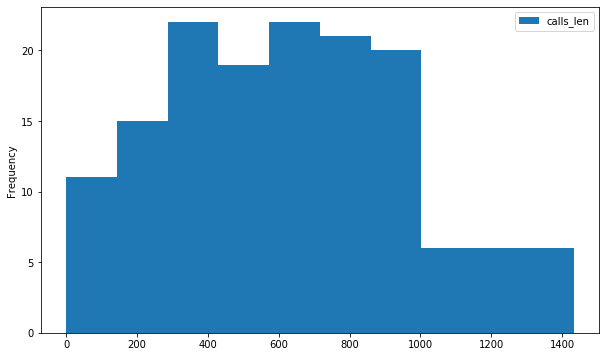

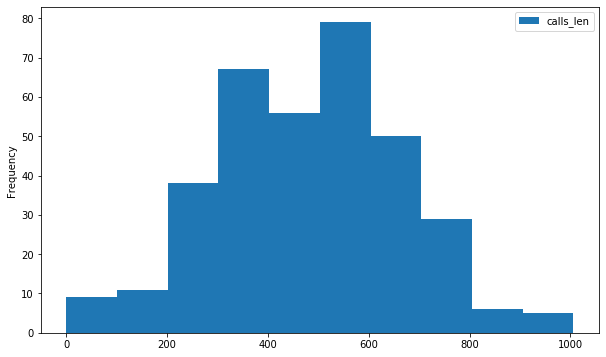

In [51]:
# построим гистограмму длительности телефонных разговоров в тарифе ультра и смарт
mediana_data1 = mediana_data.query('tariff == "ultra"')
mediana_data2 = mediana_data.query('tariff == "smart"')
mediana_data1.plot(y='calls_len', kind = 'hist',  figsize=(10, 6))
mediana_data2.plot(y='calls_len', kind = 'hist',  figsize=(10, 6))

Пользователи тарифа СМАРТ  говорят в среднем 200-600 минут, при этом лимит 500 минут-идет перерасход. У тарифа ультра лимит 3000 минут, но они их явно не выговаривают

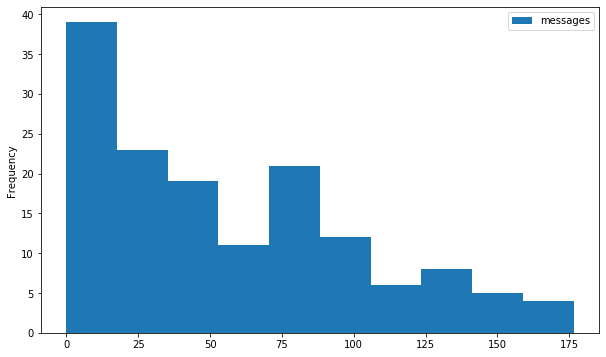

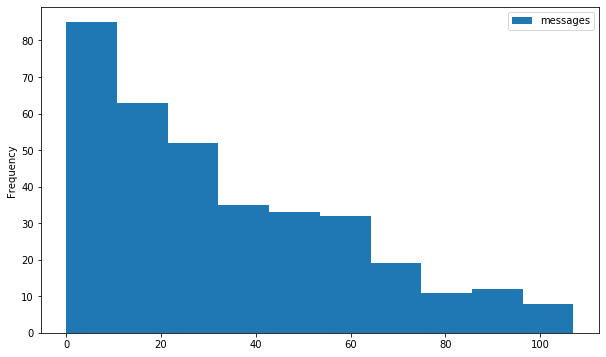

In [52]:
# построим гистограмму использования смс в тарифе ультра и смарт
mediana_data1.plot(y='messages', kind = 'hist',  figsize=(10, 6))
mediana_data2.plot(y='messages', kind = 'hist',  figsize=(10, 6))


В наше время месенджеров оба тарифа не показывают активное использование смс

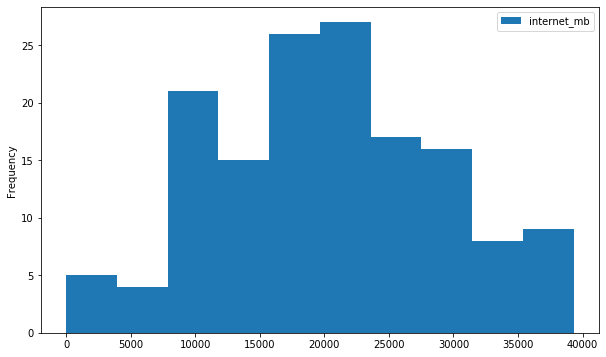

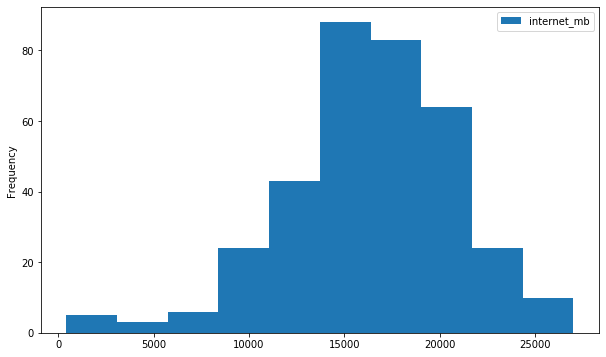

In [53]:
mediana_data1.plot(y='internet_mb', kind = 'hist',  figsize=(10, 6))
mediana_data2.plot(y='internet_mb', kind = 'hist',  figsize=(10, 6))

В ситуации с интернетом большую активность проявляют пользователи тарифа УЛЬТРА, однако на гистограмме видно что включенных 15 Гб интернета у СМАРТА явно не хватает

Более наглядную разницу двух тарифов можно увидеть на графиках seaborn

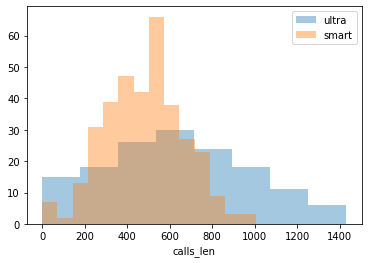

In [54]:
for tariff in ['ultra', 'smart']:
    sns.distplot(mediana_data.query('tariff == @tariff')['calls_len'], kde=False, label=tariff)
 
    _ =plt.legend(['ultra', 'smart'])
    

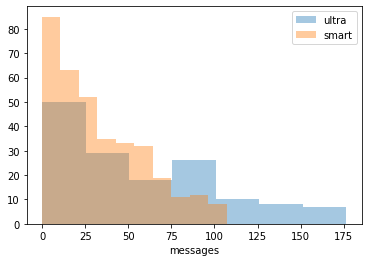

In [55]:
for tariff in ['ultra', 'smart']:
    sns.distplot(mediana_data.query('tariff == @tariff')['messages'], kde=False, label=tariff)
    _ =plt.legend(['ultra', 'smart'])
    

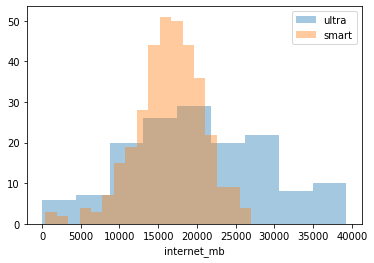

In [56]:
   for tariff in ['ultra', 'smart']:
    sns.distplot(mediana_data.query('tariff == @tariff')['internet_mb'], kde=False, label=tariff)
    _ =plt.legend(['ultra', 'smart'])

### Проверка гипотез

Чтобы понять, различаются ли средние чеки пользователей  разных тарифов, недостаточно просто сравнить числа за определённый период времени. Без проведения корректного теста нельзя считать отличия случайными или разницу достаточной, чтобы полагать расходы людей разными.
нулевая гипотеза- предположим что расходы пользователей двух тарифов не отличается.
тогда альтернативная гипоза- расходы отличаются

In [57]:
ultra = data.query('tariffs == "ultra"')['all_pay']
smart = data.query('tariffs == "smart"')['all_pay']

In [58]:
ultra.mean()

2054.1800411522636

In [59]:
smart.mean()

1304.5261958997721

Начнём с формулировки нулевой гипотезы H0: Средняя выручка тарифа СМАРТ  равна средней выручке тарифа УЛЬТРА. Проверим гипотезу что выручки двух тарифов равны
Исходя из нулевой гипотезы формулируем альтернативную гипотезу H₁. Для этой H₀ она звучит как Средняя выручка тарифа СМАРТ  не равна средней выручке тарифа УЛЬТРА
Уровень значимости для выбранной  проверки гипотезы возьмем alpha = .05

In [60]:
alpha = .05

results = st.ttest_ind(
    ultra, 
    smart)#  проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4859379263860764e-162
Отвергаем нулевую гипотезу


Получается мы не правы: по всей видимости,выручки отличаются
наблюдаемое на выборке значение попадает зону значимости, вероятность такого события при верной нулевой гипотезе признаётся слишком малым-Значит гипотеза что выручки двух тарифов равны ошибочная

построим гистограмму выручки по тарифам

In [61]:
data2=data.pivot_table(index='tariffs', values='all_pay', aggfunc='median')

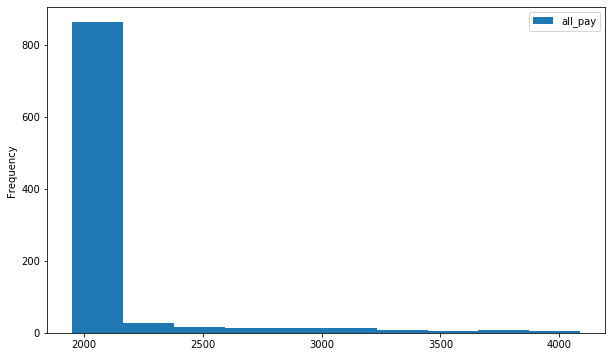

In [62]:
data2_1 = data.query('tariffs == "ultra"')
data2_2 = data.query('tariffs == "smart"')
data2_1.plot(y='all_pay', kind = 'hist',  figsize=(10, 6))#гистограмма УЛЬТРА

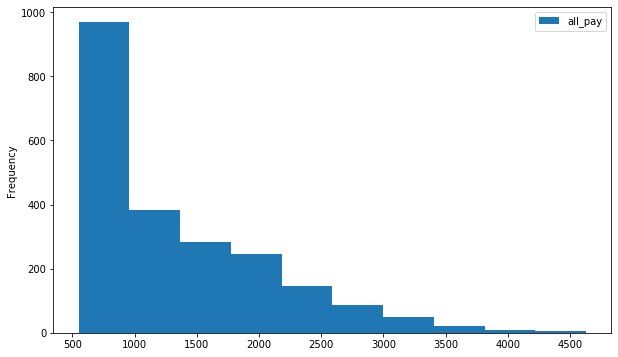

In [63]:
data2_2.plot(y='all_pay', kind = 'hist',  figsize=(10, 6))#гистограмма СМАРТ

Клиенты тарифа СМАРТ часто докупают пакеты услуг, но расходы клиенто УЛЬТРА выше

проверим нулевую гипотезу H0: Средняя выручка оператора от пользователей из Москвы равна средней выручке пользователей из регионов.

In [64]:
#рассмотрим сколько всреднем тратят москвичи
moscow_pay = data.query('city == "Москва"')['all_pay']
moscow_pay.mean()

1555.6447368421052

In [65]:
##рассмотрим сколько всреднем тратят регионы
region_pay = data.query('city != "Москва"')['all_pay']
region_pay.mean()

1529.6076592418913

H1: Средняя выручка оператора от пользователей из Москвы отличается от выручки пользователей из регионов.Чтобы проверить гипотезу о равенстве выручки в москве и ркгионах также применяем метод scipy.stats.ttest_ind

In [66]:
alpha = .05

results = st.ttest_ind(
    moscow_pay, 
    region_pay)#  проверим гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.44660386346316017
Не получилось отвергнуть нулевую гипотезу


Полученное значение p-value говорит о том, что хотя средний чек двух тарифов и неодинаков, с вероятностью в почти 44% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между выручками в Москве и регионах.

Условия применения статистического критерия т-теста (критерия Стьюдента)
— данные распределялись по закону нормального распределения;

— данные были количественными;

— и это две независимые между собой выборки (независимые это значит, что это два разных тарифа, а никак, например, до и после увеличения стоимости тарифа одной группы, люди должны быть разными, тогда группы являются несвязанными, либо независимыми), этот аспект стоит учитывать для выбора вида т-критерия Стьюдента, так как для парных выборок существует свой парный т-критерий (paired t-test).

В итоге Мы определились с тем, что это будет t-критерий Стьюдента.

### Общий вывод

Среднему пользователю тарифа СМАРТ не хватает заложенных абонентской платой лимита звонков и интернета, как следствие он вынужден доплачивать. Пользователями тарифа УЛЬТРА вероятнее всего пользуются другой категории абоненты, они чувствуют себя куда более свободно, однако заложенный тарифом лимит они не используют в полном объеме. C точки зрения доходности- клиент тарифного плана УЛЬТРА в среднем приносит больше прибыли чем пользователь тарифа СМАРТ.
Если рассматривать вопрос выручки по городам и регионам, то пользователи Москвы тратят на связь примерно столько же сколько пользователи других регионов суммарно.
С точки зрения этх двух тарифов МЕГАЛАЙНУ не хватает промежуточного тарифа, он бы подошел тем пользователям СМАРТа кто вынужден постоянно докупать недостающие ему услуги связи. И это даже не с точки зрения лишних трат-а больше со стороны комфорта.